In [1]:
import numpy as np
import pandas as pd
from qiskit import Aer
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.compiler import transpile
from qiskit.extensions import UnitaryGate
from qiskit.opflow import I, X, Y, Z, PauliTrotterEvolution, PrimitiveOp
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_histogram

In [2]:
#import the xyz files and get the atoms in a list
CO2_Ru = pd.read_csv('CO2_Ru.csv', sep=',', header=None)
print(CO2_Ru.values)

[[0.005979288 0.99249146 0.821664669 'Ru']
 [0.33942587 0.99240554 0.82141084 'Ru']
 [0.672688078 0.9924962509999999 0.82170573 'Ru']
 [0.005669844 0.242584883 0.821056225 'Ru']
 [0.339454236 0.24254530800000002 0.8214742970000001 'Ru']
 [0.67263436 0.24246511699999998 0.8217243940000001 'Ru']
 [0.0060477330000000004 0.49245470799999996 0.8215601509999999 'Ru']
 [0.339341589 0.492474495 0.8216945309999999 'Ru']
 [0.672677162 0.492498449 0.821646005 'Ru']
 [0.00605524 0.742499495 0.8216945309999999 'Ru']
 [0.339354032 0.742450547 0.821672135 'Ru']
 [0.67272939 0.74245992 0.821668402 'Ru']
 [0.155695856 0.200304108 0.953644797 'C']
 [0.242287355 0.078011041 0.9530438179999999 'O']
 [0.069166332 0.322507818 0.954249508 'O']]


In [3]:
# Brilliant.  Moving on.  
# Get the lattice vectors.
lattice_vectors = pd.read_csv('lattice_vectors.csv', sep=',', header=None)
print(lattice_vectors.values)

[[ 8.31557575  0.          0.        ]
 [ 5.54371717  9.60199979  0.        ]
 [ 0.          0.         26.78963917]]


In [4]:
# Convert to Angstroms instead of fractions of the unit cell vectors.
# An N-atom by 3 matrix times 3x3 lattice matrix yields an Nx3 matrix.
CO2_Ru_angs=np.matmul(CO2_Ru.iloc[:, 0:3],lattice_vectors)
CO2_Ru_angs = np.array(CO2_Ru_angs)
print(CO2_Ru_angs)

[[ 5.55181317  9.52990279 22.0121    ]
 [ 8.32413716  9.52907779 22.00530001]
 [11.09590717  9.5299488  22.01320001]
 [ 1.39197     2.3293     21.99580001]
 [ 4.16736     2.32892    22.007     ]
 [ 6.9375      2.32815    22.01370001]
 [ 2.78032     4.72855    22.0093    ]
 [ 5.55196     4.72874    22.01289999]
 [ 8.32397     4.72897    22.0116    ]
 [ 4.16656     7.12948    22.01289999]
 [ 6.93786     7.12901    22.01230001]
 [ 9.71012     7.1291     22.01220001]
 [ 2.40513001  1.92332    25.54780001]
 [ 2.44723     0.749062   25.5317    ]
 [ 2.36305     3.09672    25.564     ]]


In [5]:
# Slice off unnecessary z-space below.  Convert to atomic units of length.
CO2_Ru_angs[:, 2] = CO2_Ru_angs[:, 2] - 20
CO2_Ru_au = CO2_Ru_angs/0.52917721067121
print(CO2_Ru_au)

[[10.49140638 18.00890628  3.80231794]
 [15.73033946 18.00734725  3.78946783]
 [20.96822566 18.00899321  3.80439666]
 [ 2.63044207  4.40173906  3.77151541]
 [ 7.87516906  4.40102096  3.79268034]
 [13.109975    4.39956588  3.80534152]
 [ 5.25404334  8.93566448  3.79702671]
 [10.49168386  8.93602352  3.80382971]
 [15.73002358  8.93645816  3.80137307]
 [ 7.87365729 13.47276461  3.80382971]
 [13.1106553  13.47187644  3.80269591]
 [18.34946745 13.47204652  3.80250692]
 [ 4.54503701  3.63454806 10.48382261]
 [ 4.62459447  1.41552203 10.453398  ]
 [ 4.46551732  5.85195269 10.51443616]]


In [6]:
a1 = 24

In [7]:
CO2_Ru = np.array(CO2_Ru)
split = np.linspace(0,a1,16)
#print(split_x)

V_ext_x = []

for i in split:
    #V_ext = 0
    mini_sum = 0
    for j in range(len(CO2_Ru_angs)):

        distance_x = np.sqrt(np.power(CO2_Ru_au[j,0] - i,2))


        pseudopotential_x = np.exp(-np.power(distance_x/(1),2))

        #print(pseudopotential)
        element = CO2_Ru[j,3]
        if element == 'Ru':
            charge = 10#44
        elif element == 'C':
            charge = 6
        elif element == 'O':
            charge = 8
        else:
            charge = 0.0
            
        mini_sum = mini_sum-28*charge*pseudopotential_x #28 is all the valence electrons of the system
        
    V_ext_x.append(mini_sum) 


print(min(V_ext_x))
print(np.sum(V_ext_x)/16)
V_ext_oper = np.diag(V_ext_x)
#V_ext_oper[0,0] = -V_ext
print(V_ext_x)
print(V_ext_oper)

-805.3404953355378
-276.6658681789154
[-0.27680747747231244, -96.94598382969153, -308.6574331998996, -805.3404953355378, -159.2685513985877, -552.5175040238388, -281.43623470345307, -353.5836040621065, -511.4095441384343, -201.57397803481211, -521.9335171768768, -176.6445139992814, -148.1129775191456, -272.877621838253, -36.04659603406548, -0.028528091189987947]
[[-2.76807477e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -9.69459838e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -3.08657433e+02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00

In [8]:
V_nuc_scalar = 0
for k in range(len(CO2_Ru_au)):
    for l in range(len(CO2_Ru_au)):
        if k!=l:
            distance = np.sqrt(np.sum(np.power(CO2_Ru_au[k,:] - CO2_Ru_au[l,:],2)))
            element1 = CO2_Ru[k,3]
            if element1 == 'Ru':
                charge1 = 44
            elif element1 == 'C':
                charge1 = 6
            elif element1 == 'O':
                charge1 = 8
            else:
                charge1 = 0.0
            element2 = CO2_Ru[l,3]
            if element2 == 'Ru':
                charge2 = 44
            elif element2 == 'C':
                charge2 = 6
            elif element2 == 'O':
                charge2 = 8
            else:
                charge2 = 0.0
            pseudopotential = charge1*charge2*np.exp(-np.power(distance/(1),2))
            V_nuc_scalar += charge*pseudopotential/2 #Divided by two because otherwise every pair interaction is counted twice
print(V_nuc_scalar)

5.562562074832925


In [9]:
# Define the coefficients for the D matrix
d = V_ext_oper

# Construct the D matrix
D = Operator(np.zeros((16, 16)))
i = 0
for P1 in [(I+Z)/2, (I-Z)/2]:
    for P2 in [(I+Z)/2, (I-Z)/2]:
        for P3 in [(I+Z)/2, (I-Z)/2]:
            for P4 in [(I+Z)/2, (I-Z)/2]:
                D = D + d[i][i] * Operator(P1^P2^P3^P4)
                i += 1
                
# Define the given expression
expr = 2 * Operator(I^I^I^I) \
       - Operator(I^I^I^X) \
       - 0.5 * Operator(I^I^X^X) \
       + 0.5 * Operator(I^I^(1j*Y)^(1j*Y)) \
       - 0.25 * Operator((I+X)^X^X^X) \
       - 0.25 * Operator((I+X)^X^(1j*Y)^(1j*Y)) \
       + 0.25 * Operator((I-X)^(1j*Y)^X^(1j*Y)) \
       + 0.25 * Operator((I-X)^(1j*Y)^(1j*Y)^X)

# Compute and print the result
result = -(1/np.power((a1/2),2))*expr + D + (V_nuc_scalar + a1/16)*(I^I^I^I)
result = result/100
# print(result)

In [10]:
np.linalg.eig(result)

(array([-7.98291822+0.j,  0.06771672+0.j,  0.07020341+0.j, -0.89897311+0.j,
        -0.28997924+0.j, -3.0160876 +0.j, -2.65828949+0.j, -5.45468831+0.j,
        -1.41064302+0.j, -1.52219878+0.j, -1.69595842+0.j, -5.14884844+0.j,
        -2.74387561+0.j, -3.46534931+0.j, -1.94525305+0.j, -5.04360871+0.j]),
 array([[-7.10116212e-16+0.j,  9.99609671e-01+0.j,  2.79374299e-02+0.j,
         -7.18372153e-05+0.j,  3.74315836e-08+0.j,  7.38658305e-10-0.j,
         -1.90118448e-14+0.j,  2.64775432e-24-0.j, -7.59788988e-18+0.j,
          2.43181675e-18-0.j,  1.34310465e-21-0.j,  2.63736876e-29+0.j,
         -4.62344134e-27+0.j, -1.52007061e-31+0.j, -3.80964669e-30+0.j,
          3.21476210e-37+0.j],
        [ 1.37062907e-10-0.j,  7.18093192e-05+0.j,  2.00180182e-06+0.j,
          9.99999997e-01+0.j,  4.26840207e-12+0.j, -3.28014591e-05+0.j,
          7.49131869e-19-0.j, -2.10317482e-19+0.j,  5.93107043e-21-0.j,
         -5.56759545e-14+0.j, -5.39895940e-24+0.j,  1.78230449e-28+0.j,
          1.856

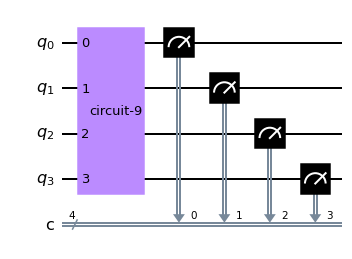

In [11]:
t = Parameter('t')
time_evolution_operator = (t*PrimitiveOp(result)).exp_i()
trotter_exponentiation_circuit = PauliTrotterEvolution().convert(time_evolution_operator)
bound_trotter_exponentiation_circuit = trotter_exponentiation_circuit.bind_parameters({t: 0.1*np.pi})

Full_Trott = bound_trotter_exponentiation_circuit
for i in range(19):
    Full_Trott = Full_Trott @ bound_trotter_exponentiation_circuit

# print(total_time_evolution_circuit)

# Full_Trott = Full_Trott.to_instruction()

qc = QuantumCircuit(4, 4)
qc.append(Full_Trott, [0, 1, 2, 3])
qc.measure([0, 1, 2, 3], [0, 1, 2, 3])
qc.draw('mpl')

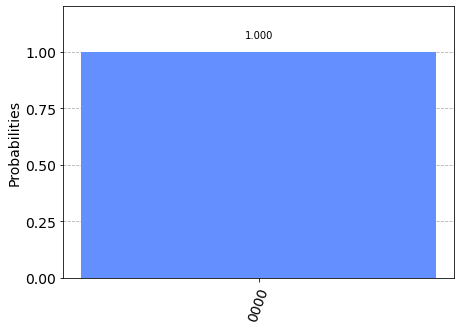

In [12]:
shots = 2000
sim = Aer.get_backend('aer_simulator')
qc_trans = transpile(qc, sim)
counts = sim.run(qc_trans, shots=shots).result().get_counts()
plot_histogram(counts)

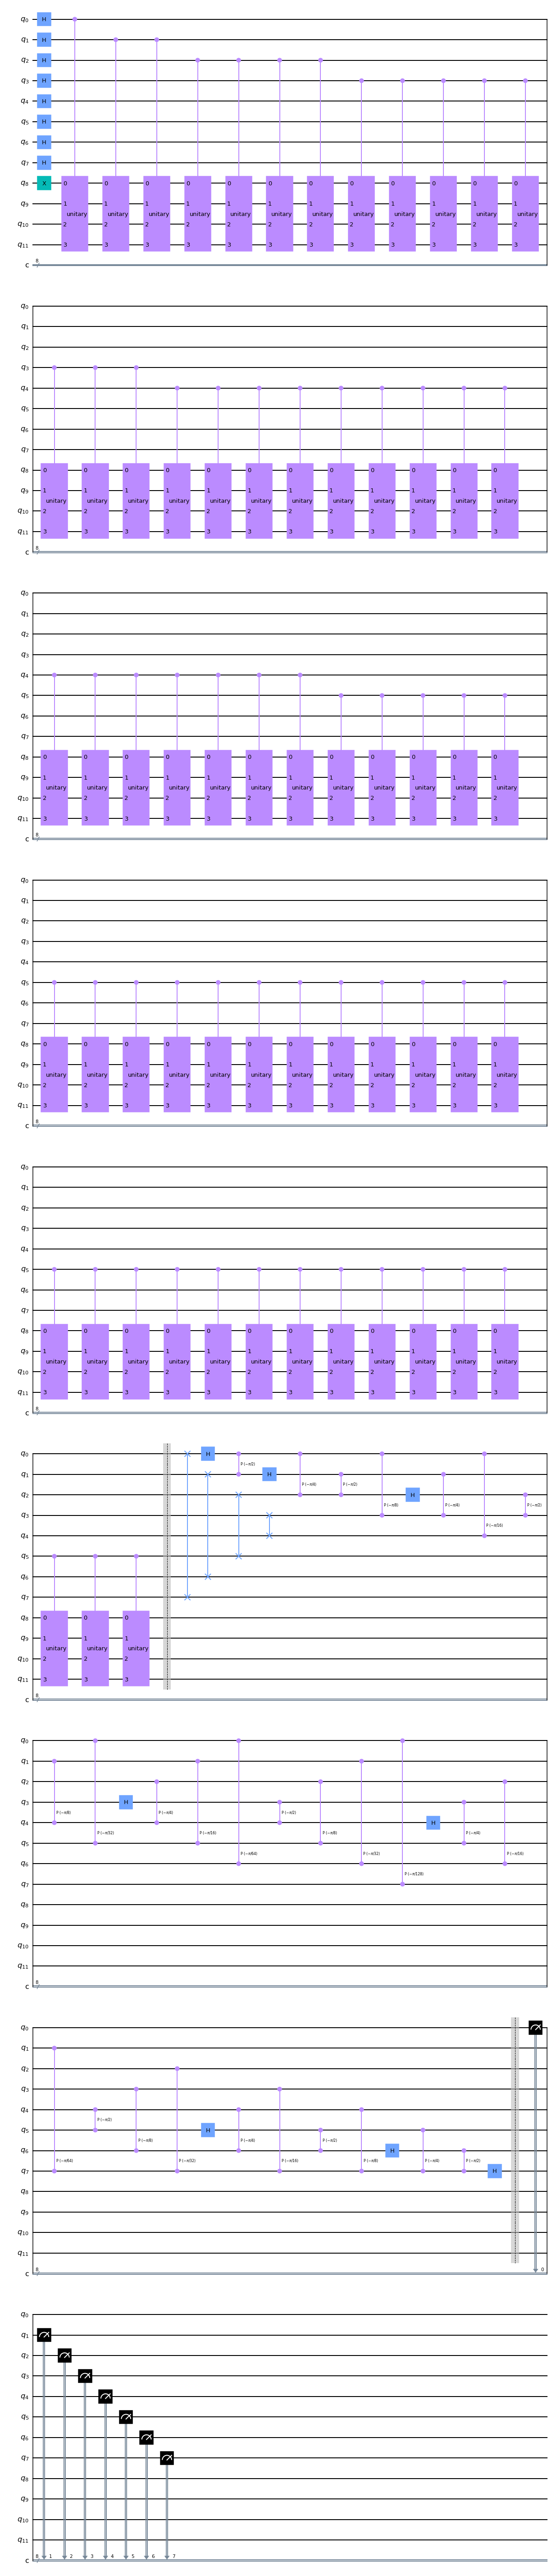

In [13]:
qpe = QuantumCircuit(12, 8)

for qubit in range(8):
    qpe.h(qubit)

qpe.x(8)
    
Controlled_Trott = UnitaryGate(Full_Trott).control(1)

repetitions = 1
for counting_qubit in range(6):
    for i in range(repetitions):
        qpe.append(Controlled_Trott,[counting_qubit,8,9,10,11])
        # qpe.append(Full_Trott,qargs=[8,9,10,11], cargs=[counting_qubit])
    repetitions *= 2
    
def qft_dagger(qc, n):
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
        
qpe.barrier()
qft_dagger(qpe, 8)
qpe.barrier()
for n in range(8):
    qpe.measure(n,n)
    
qpe.draw('mpl')

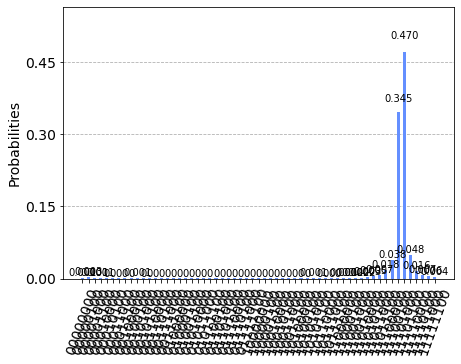

In [14]:
shots = 5000
sim = Aer.get_backend('aer_simulator')
qpe_trans = transpile(qpe, sim)
counts = sim.run(qpe_trans, shots=shots).result().get_counts()
plot_histogram(counts)

In [15]:
print(counts)

{'10101000': 6, '11100100': 1726, '11011100': 88, '11100000': 192, '10100100': 4, '11101000': 2350, '11010000': 17, '11101100': 242, '11001100': 10, '00000100': 17, '11110000': 81, '11110100': 37, '00001000': 6, '11111100': 18, '11000000': 7, '01110100': 2, '11011000': 36, '01101100': 3, '00001100': 6, '01110000': 3, '11000100': 9, '10011100': 2, '01000100': 4, '10000000': 1, '00110000': 2, '00110100': 4, '00101100': 1, '11001000': 8, '11010100': 25, '11111000': 30, '10101100': 3, '10000100': 2, '01011100': 1, '00010100': 1, '01011000': 2, '00000000': 7, '01111100': 3, '00101000': 2, '10011000': 1, '00011100': 4, '00111100': 2, '00100100': 5, '01001100': 1, '10010100': 1, '01100100': 1, '10111000': 4, '00100000': 1, '01000000': 1, '10111100': 3, '10001100': 1, '00011000': 4, '00010000': 3, '01101000': 2, '10110000': 2, '00111000': 1, '10100000': 2, '10010000': 1, '01111000': 1, '01010000': 1}
